In [1]:
import FairBoost
from FairBoost import FairBoostRegressor
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from scipy import stats
from sklearn import datasets
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.cross_validation import cross_val_predict
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cross_validation import *
from sklearn.ensemble import AdaBoostRegressor
# from sklearn.ensemble import FairBoostRegressor
from sklearn.tree import DecisionTreeRegressor
# from sklearn.model_selection import train_test_split
%matplotlib inline
%precision %.2f
pd.options.display.float_format = '{:,.2f}'.format

X = pickle.load( open( "x.p", "rb" ) )
y = pickle.load( open( "y.p", "rb" ) )
g = pickle.load( open( "g.p", "rb" ) )
g=np.nan_to_num(g)
g0 = np.nan_to_num([i for i,x in enumerate(g) if x==0])
g1 = np.nan_to_num([i for i,x in enumerate(g) if x==1])

fbt = FairBoostRegressor(DecisionTreeRegressor(max_depth=4),n_estimators=1, random_state=25)
fbt.setGroups(g)

fbt.fit(X,y)
train_pred = fbt.predict(X)
print('train error iteration 1 ', mean_squared_error(train_pred, y))

fbt = FairBoostRegressor(DecisionTreeRegressor(max_depth=4),n_estimators=10, random_state=25)
fbt.setGroups(g)

fbt.fit(X,y)
train_pred = fbt.predict(X)
print('train error iteration 10 ', mean_squared_error(train_pred, y))

train error iteration 1  0.0566338971958
train error iteration 10  0.0192470067531


/home/caitlin/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [7]:
#Error metrics

#summary of deviation measures - relates to precision/accuracy?
# https://en.wikipedia.org/wiki/Deviation_(statistics)#Unsigned_or_absolute_deviation
#https://en.wikipedia.org/wiki/Mean_signed_deviation
#signed absolute deviation ?
# https://en.wikipedia.org/wiki/Average_absolute_deviation
#average absolute deviation

def get_ae(vals):
    return np.sum([math.fabs(x[0]-x[1]) for x in vals])

def get_mae(vals):
    m = np.sum([math.fabs(x[0]-x[1]) for x in vals])
    return m/len(vals)


def get_se(vals):
    return np.sum([math.pow(x[0]-x[1], 2) for x in vals])
    
def get_mse(vals):
    m = np.sum([math.pow(x[0]-x[1], 2) for x in vals])
    return m/len(vals)

#overestimate
def get_oe(vals):
    return np.sum([max(0,x[0]-x[1]) for x in vals])

def get_moe(vals):
    m = np.sum([max(0,x[0]-x[1]) for x in vals])
    return m/len(vals)

#underestimate
def get_ue(vals):
    return np.sum([min(0,x[0]-x[1]) for x in vals])

def get_mue(vals):
    m = np.sum([min(0,x[0]-x[1]) for x in vals])
    return m/len(vals)

error_functs = [get_ae, get_mae, get_se, get_mse, get_oe, get_moe, get_ue, get_mue]
##### BIN ERRORS: ###########

def get_bin_width(data, n):
    return (data.max()-data.min())/(n+1)

def get_error_binned_eq_depth_by_group(points, nbins, error=get_mse):
    mse = []
    kf = KFold(n_splits=nbins, shuffle=True, random_state=10)
    for rest, bin in kf.split(points):
        vals = [points.iloc[i] for i in bin]
        mse.append(error(vals))
    return mse

def plot_binned_error(df, error=get_mse):
    indices =np.arange(df.shape[0])
    #Calculate optimal width
    width = 0.3

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.bar(indices-width,df[df.columns[0]],width,color='b',label='-Ymin')
    ax.bar(indices,df[df.columns[1]],width,color='r',label='Ymax')
    ax.set_xlim(left=-1,right=len(df))
    ax.set_ylim([0,1])
    ax.set_xlabel('Bin')
    ax.set_ylabel(error.__name__)
    plt.show()


 decision tree error:  0.22793507807

 Fair Boost tree error:  0.0889166040405
dt fair error:  0.737375323668
fbt fair error:  0.455030961258
group0:  (42, 3)
group1:  (29, 3)


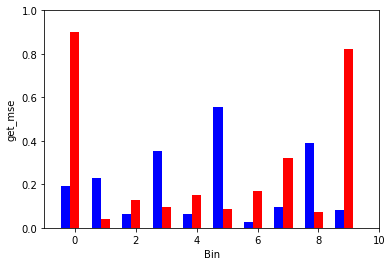

group0:  (42, 3)
group1:  (29, 3)


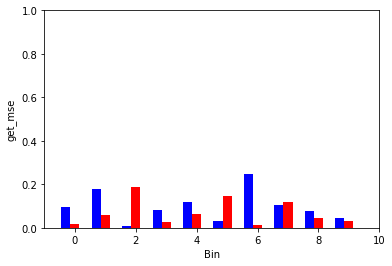


 decision tree error:  0.136195300874

 Fair Boost tree error:  0.125640539733
dt fair error:  0.548048317048
fbt fair error:  0.342957233973
group0:  (33, 3)
group1:  (38, 3)


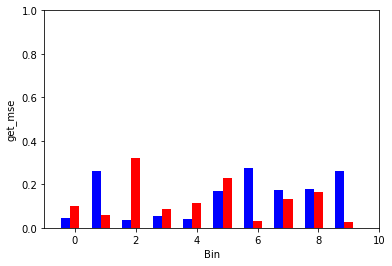

group0:  (33, 3)
group1:  (38, 3)


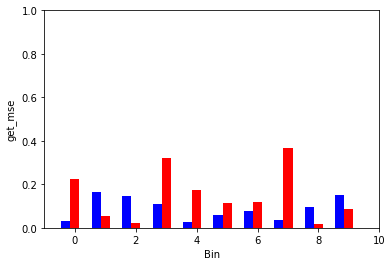

In [8]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=2, shuffle=True, random_state=1)

nbins=10
for train_index, test_index in kf.split(X):
    dt = DecisionTreeRegressor(max_depth=4)
    fbt = FairBoostRegressor(DecisionTreeRegressor(max_depth=4),n_estimators=500, random_state=25)
    dt.fit(X[train_index],y[train_index])
    fbt.setGroups(g[train_index])
    fbt.fit(X[train_index],y[train_index])
    dt_pred = dt.predict(X[test_index])
    fbt_pred = fbt.predict(X[test_index])
    
    print('\n decision tree error: ', mean_squared_error(dt_pred, y[test_index]))
    print('\n Fair Boost tree error: ', mean_squared_error(fbt_pred, y[test_index]))
    
    g0 = [i for i,x in enumerate(g[test_index]) if x==0]
    g1 = [i for i,x in enumerate(g[train_index]) if x==1]
    bins0,bins1  = fbt.recomputeBins(dt_pred, g0, g1, nbins)
    error_vect=np.abs(dt_pred - y[test_index])
    e0=[np.sum([error_vect[i] for i in b]) for b in bins0]
    e1=[np.sum([error_vect[i] for i in b]) for b in bins1]
    bin_error = np.subtract(e0, e1)
    print("dt fair error: ", np.mean(np.abs(bin_error)))
    
    bins0,bins1  = fbt.recomputeBins(fbt_pred, g0, g1, nbins)
    error_vect=np.abs(fbt_pred - y[test_index])
    e0=[np.sum([error_vect[i] for i in b]) for b in bins0]
    e1=[np.sum([error_vect[i] for i in b]) for b in bins1]
    bin_error = np.subtract(e0, e1)
    print("fbt fair error: ", np.mean(np.abs(bin_error)))
    
    ### PLOTTING ###
    results = pd.DataFrame()
    results['pred'] = dt_pred
    results['y'] = y[test_index]
    results['g'] = g[test_index]
    results = results.sort_values('pred')
    results0 = results[results['g']==0]
    print ("group0: ", results0.shape)
    results1 = results[results['g']==1]
    print ("group1: ", results1.shape)
    
    mse_df_depth = pd.DataFrame()
    mse_df_depth['mse0'] = get_error_binned_eq_depth_by_group(results0, nbins, error=get_mse)
    mse_df_depth['mse1'] = get_error_binned_eq_depth_by_group(results1, nbins, error=get_mse)
    plot_binned_error(mse_df_depth)
    
    
    results = pd.DataFrame()
    results['pred'] = fbt_pred
    results['y'] = y[test_index]
    results['g'] = g[test_index]
    results = results.sort_values('pred')
    results0 = results[results['g']==0]
    print ("group0: ", results0.shape)
    results1 = results[results['g']==1]
    print ("group1: ", results1.shape)
   
    mse_df_depth = pd.DataFrame()
    mse_df_depth['mse0'] = get_error_binned_eq_depth_by_group(results0, nbins, error=get_mse)
    mse_df_depth['mse1'] = get_error_binned_eq_depth_by_group(results1, nbins, error=get_mse)
    # using equal width bins  - which one gives more comparable plot?
    plot_binned_error(mse_df_depth)

In [ ]:
TODO:
    Not producing any consistent results
    Try different ways of updating the weights bin-wise
    is error being computed as mse? investigate error_vect
    read up on non-differentiable error in boosting. Are we just jumping around?
    try plotting change in bin_error over iterations